# Moving average bias correction for road temperature


Using a simple moving average approach for bias correction of road temperature on specific stations

In [2]:

import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #bb
from sklearn import linear_model


import matplotlib.pyplot as plt

# no need for these here
#Import a tool for helping make figures
#from climetlab_mltc_surface_observation_postprocessing.utils import imgBufferFromVectors

# CliMetLab will be used to manage the data loading.
#import climetlab as cml


import pandas as pd
import sqlite3
import os

### Read the data and calculate the bias

In [52]:
DATADIR="/media/cap/extra_work/data/road_model"
df_glat=pd.read_csv(os.path.join(DATADIR,"TROAD_glatmodel_data.csv.gz"),compression="gzip")


obs_temp_array = df_glat["obs_temp"].values.reshape(-1, 1)

forecast_temp_array = df_glat["forecast_temp"].values.reshape(-1, 1)

# Convert the "obs_temp" column to a NumPy array with shape (544920, 1)
obs_temp_array = df_glat["obs_temp"].values.reshape(-1, 1)

# Calculate the bias (forecast_temp - obs_temp)
forecast_error = forecast_temp_array - obs_temp_array
df_glat["validity_time"] = pd.to_datetime(df_glat["validity_time"])


### A few steps that might be unnecessary later on (datetimes processin) but leaving them here for the moment

In [54]:

df_glat['unix_timestamp'] = (df_glat['validity_time'].values.astype(np.int64) / 1e9)
#df_glat["unix_timestamp"]

In [55]:
#time_of_day = df_glat["unix_timestamp"].values.reshape(-1,1)
#time_of_day
time_of_day = df_glat["lead_hrs"].values.reshape(-1,1)

In [56]:
# Add the information from the lat, lon and height as well as the 2m temperature
con = sqlite3.connect("/media/cap/extra_work/data/road_model/stations_coords_height.db")

query="SELECT * FROM roadstations;"
df_geo = pd.read_sql(query, con)
con.close()
df_geo.rename(columns={"SID":"site_ID"},inplace=True)

#df_geo

df_merged = pd.merge(df_glat, df_geo, on='site_ID', how='left')
#df_glat
#df_geo = df_geo.rename({"SID":"site_ID"},inplace=True)
#df_geo
#df_coords = pd.read_csv()

In [57]:
#df_merged.drop(columns=["forecast_temp"],inplace=True)
df_merged.drop(columns=["obs_temp","model_type","model_ID"],inplace=True)

In [58]:
df_merged

,site_ID,init_time,validity_time,lead_hrs,forecast_temp,unix_timestamp,lon,lat,height
0,100001,2023-01-11T00:00:00Z,2023-01-11 02:00:00+00:00,2,4.29,1.673402e+09,12.486580,55.995688,58.560295
1,100001,2023-01-11T00:00:00Z,2023-01-11 03:00:00+00:00,3,4.36,1.673406e+09,12.486580,55.995688,58.560295
2,100001,2023-01-11T00:00:00Z,2023-01-11 04:00:00+00:00,4,4.41,1.673410e+09,12.486580,55.995688,58.560295
3,100001,2023-01-11T00:00:00Z,2023-01-11 05:00:00+00:00,5,4.60,1.673413e+09,12.486580,55.995688,58.560295
4,100001,2023-01-11T00:00:00Z,2023-01-11 06:00:00+00:00,6,4.96,1.673417e+09,12.486580,55.995688,58.560295
...,...,...,...,...,...,...,...,...,...
544915,100900,2023-03-30T23:00:00Z,2023-03-31 18:00:00+00:00,19,9.29,1.680286e+09,11.950133,55.738069,10.844472
544916,100900,2023-03-30T23:00:00Z,2023-03-31 19:00:00+00:00,20,7.92,1.680289e+09,11.950133,55.738069,10.844472
544917,100900,2023-03-30T23:00:00Z,2023-03-31 20:00:00+00:00,21,6.98,1.680293e+09,11.950133,55.738069,10.844472
544918,100900,2023-03-30T23:00:00Z,2023-03-31 21:00:00+00:00,22,6.38,1.680296e+09,11.950133,55.738069,10.844472


In [59]:
df_merged.dtypes

site_ID                         int64
init_time                      object
validity_time     datetime64[ns, UTC]
lead_hrs                        int64
forecast_temp                 float64
unix_timestamp                float64
lon                           float64
lat                           float64
height                        float64
dtype: object

In [60]:
# Calculate mean error
mean_error = np.mean(forecast_temp_array - obs_temp_array)

In [61]:
#test to check shape of arrays
#forecast_data = np.random.normal(loc=18, scale=6, size=30)  # Sample forecast data
#forecast_data

In [62]:
forecast_temp_array[:,0]

array([4.29, 4.36, 4.41, ..., 6.98, 6.38, 5.93])

In [63]:
# Apply moving average to forecast data
#this uses a non weighted moving average
window_size = 3  # Example window size, using 3 hours in this case
smoothed_forecast = np.convolve(forecast_temp_array[:,0], np.ones(window_size)/window_size, mode='valid')


In [64]:
smoothed_forecast

array([4.35333333, 4.45666667, 4.65666667, ..., 8.06333333, 7.09333333,
       6.43      ])

In [65]:
np.ones(window_size)/window_size

array([0.33333333, 0.33333333, 0.33333333])

In [66]:
# Adjust forecast by adding mean error to smoothed forecast
corrected_forecast = smoothed_forecast + mean_error

# Print the mean error and corrected forecast
print("Mean Error:", mean_error)
print("Corrected Forecast (Adjusted by Mean Error):", corrected_forecast)

Mean Error: -0.03046225451258898
Corrected Forecast (Adjusted by Mean Error): [4.32287108 4.42620441 4.62620441 ... 8.03287108 7.06287108 6.39953775]


In [67]:
smoothed_forecast.shape

(544918,)

In [68]:
obs_temp_array[:,0].shape

(544920,)

In [69]:
initial_mean_error = np.mean(forecast_temp_array - obs_temp_array)


In [70]:
initial_mean_error

-0.03046225451258898

In [71]:
final_mean_error = np.mean(smoothed_forecast - obs_temp_array[:len(smoothed_forecast),0])


In [72]:
final_mean_error

-0.03045996840319727

In [74]:
# Selecting one station
SID_sel = 100001

In [76]:
df_sel = df_glat[df_glat["site_ID"] == SID_sel]


In [77]:
df_sel

,site_ID,model_type,model_ID,init_time,validity_time,lead_hrs,forecast_temp,obs_temp,unix_timestamp
0,100001,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 02:00:00+00:00,2,4.29,3.8,1.673402e+09
1,100001,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 03:00:00+00:00,3,4.36,3.9,1.673406e+09
2,100001,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 04:00:00+00:00,4,4.41,4.0,1.673410e+09
3,100001,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 05:00:00+00:00,5,4.60,4.2,1.673413e+09
4,100001,glatmodel,glatmodel,2023-01-11T00:00:00Z,2023-01-11 06:00:00+00:00,6,4.96,4.7,1.673417e+09
...,...,...,...,...,...,...,...,...,...
537180,100001,glatmodel,glatmodel,2023-03-30T23:00:00Z,2023-03-31 18:00:00+00:00,19,6.15,6.6,1.680286e+09
537181,100001,glatmodel,glatmodel,2023-03-30T23:00:00Z,2023-03-31 19:00:00+00:00,20,5.61,5.9,1.680289e+09
537182,100001,glatmodel,glatmodel,2023-03-30T23:00:00Z,2023-03-31 20:00:00+00:00,21,5.21,5.1,1.680293e+09
537183,100001,glatmodel,glatmodel,2023-03-30T23:00:00Z,2023-03-31 21:00:00+00:00,22,4.87,4.4,1.680296e+09


In [78]:
df_sel.drop(columns=["site_ID","model_type","model_ID"],inplace=True)

/tmp/ipykernel_76904/121824800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.drop(columns=["site_ID","model_type","model_ID"],inplace=True)


In [79]:
df_sel

,init_time,validity_time,lead_hrs,forecast_temp,obs_temp,unix_timestamp
0,2023-01-11T00:00:00Z,2023-01-11 02:00:00+00:00,2,4.29,3.8,1.673402e+09
1,2023-01-11T00:00:00Z,2023-01-11 03:00:00+00:00,3,4.36,3.9,1.673406e+09
2,2023-01-11T00:00:00Z,2023-01-11 04:00:00+00:00,4,4.41,4.0,1.673410e+09
3,2023-01-11T00:00:00Z,2023-01-11 05:00:00+00:00,5,4.60,4.2,1.673413e+09
4,2023-01-11T00:00:00Z,2023-01-11 06:00:00+00:00,6,4.96,4.7,1.673417e+09
...,...,...,...,...,...,...
537180,2023-03-30T23:00:00Z,2023-03-31 18:00:00+00:00,19,6.15,6.6,1.680286e+09
537181,2023-03-30T23:00:00Z,2023-03-31 19:00:00+00:00,20,5.61,5.9,1.680289e+09
537182,2023-03-30T23:00:00Z,2023-03-31 20:00:00+00:00,21,5.21,5.1,1.680293e+09
537183,2023-03-30T23:00:00Z,2023-03-31 21:00:00+00:00,22,4.87,4.4,1.680296e+09


### Using moving average correction for specific stations

In [92]:
#Want to use a separate MA for each forecast cycle
df_sel["init_time"] = pd.to_datetime(df_sel["init_time"])

/tmp/ipykernel_76904/1767574826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["init_time"] = pd.to_datetime(df_sel["init_time"])


In [93]:
df_sel["init_time"].values[0]

numpy.datetime64('2023-01-11T00:00:00.000000000')

In [94]:
df_cy_00 = df_sel[df_sel['init_time'].dt.hour == 0]
df_cy_00

,init_time,validity_time,lead_hrs,forecast_temp,obs_temp,unix_timestamp
0,2023-01-11 00:00:00+00:00,2023-01-11 02:00:00+00:00,2,4.29,3.8,1.673402e+09
1,2023-01-11 00:00:00+00:00,2023-01-11 03:00:00+00:00,3,4.36,3.9,1.673406e+09
2,2023-01-11 00:00:00+00:00,2023-01-11 04:00:00+00:00,4,4.41,4.0,1.673410e+09
3,2023-01-11 00:00:00+00:00,2023-01-11 05:00:00+00:00,5,4.60,4.2,1.673413e+09
4,2023-01-11 00:00:00+00:00,2023-01-11 06:00:00+00:00,6,4.96,4.7,1.673417e+09
...,...,...,...,...,...,...
339794,2023-03-31 00:00:00+00:00,2023-03-31 18:00:00+00:00,18,5.89,6.6,1.680286e+09
339795,2023-03-31 00:00:00+00:00,2023-03-31 19:00:00+00:00,19,5.46,5.9,1.680289e+09
339796,2023-03-31 00:00:00+00:00,2023-03-31 20:00:00+00:00,20,4.98,5.1,1.680293e+09
339797,2023-03-31 00:00:00+00:00,2023-03-31 21:00:00+00:00,21,4.57,4.4,1.680296e+09


In [95]:
df_cy_01 = df_sel[df_sel['init_time'].dt.hour == 1]
df_cy_01

,init_time,validity_time,lead_hrs,forecast_temp,obs_temp,unix_timestamp
5988,2023-01-11 01:00:00+00:00,2023-01-11 02:00:00+00:00,1,3.84,3.8,1.673402e+09
5989,2023-01-11 01:00:00+00:00,2023-01-11 03:00:00+00:00,2,3.93,3.9,1.673406e+09
5990,2023-01-11 01:00:00+00:00,2023-01-11 04:00:00+00:00,3,4.13,4.0,1.673410e+09
5991,2023-01-11 01:00:00+00:00,2023-01-11 05:00:00+00:00,4,4.36,4.2,1.673413e+09
5992,2023-01-11 01:00:00+00:00,2023-01-11 06:00:00+00:00,5,4.78,4.7,1.673417e+09
...,...,...,...,...,...,...
348497,2023-03-31 01:00:00+00:00,2023-03-31 18:00:00+00:00,17,5.59,6.6,1.680286e+09
348498,2023-03-31 01:00:00+00:00,2023-03-31 19:00:00+00:00,18,5.19,5.9,1.680289e+09
348499,2023-03-31 01:00:00+00:00,2023-03-31 20:00:00+00:00,19,4.77,5.1,1.680293e+09
348500,2023-03-31 01:00:00+00:00,2023-03-31 21:00:00+00:00,20,4.33,4.4,1.680296e+09


### Correction for cycle 00

In [97]:
df_cy_00.dtypes

init_time         datetime64[ns, UTC]
validity_time     datetime64[ns, UTC]
lead_hrs                        int64
forecast_temp                 float64
obs_temp                      float64
unix_timestamp                float64
dtype: object

In [100]:
# Calculate the error between forecasted and observed temperatures
df_cy_00['error'] = df_cy_00['forecast_temp'] - df_cy_00['obs_temp']

# Function to calculate mean error over a rolling window
def calculate_mean_error(df, window_size):
    df['mean_error'] = df.groupby('lead_hrs')['error'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    return df

# Specify the window size (e.g., 3 days)
window_size = 3

# Calculate the mean error over the specified window
df_with_mean_error = calculate_mean_error(df_cy_00, window_size)

# Extract the most recent mean error for the current forecast
current_forecast_mean_error = df_with_mean_error.groupby('lead_hrs').tail(1)

df_with_mean_error['corrected_forecast_temp'] = df_with_mean_error['forecast_temp'] - df_with_mean_error['mean_error']

#print(df_with_mean_error)
#print("\nCurrent Forecast Mean Error:\n", current_forecast_mean_error)

/tmp/ipykernel_76904/2756598852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cy_00['error'] = df_cy_00['forecast_temp'] - df_cy_00['obs_temp']
/tmp/ipykernel_76904/2756598852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_error'] = df.groupby('lead_hrs')['error'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
/tmp/ipykernel_76904/2756598852.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,init_time,validity_time,lead_hrs,forecast_temp,obs_temp,unix_timestamp,error,mean_error,corrected_forecast_temp
0,2023-01-11 00:00:00+00:00,2023-01-11 02:00:00+00:00,2,4.29,3.8,1.673402e+09,0.49,0.490000,3.800000
1,2023-01-11 00:00:00+00:00,2023-01-11 03:00:00+00:00,3,4.36,3.9,1.673406e+09,0.46,0.460000,3.900000
2,2023-01-11 00:00:00+00:00,2023-01-11 04:00:00+00:00,4,4.41,4.0,1.673410e+09,0.41,0.410000,4.000000
3,2023-01-11 00:00:00+00:00,2023-01-11 05:00:00+00:00,5,4.60,4.2,1.673413e+09,0.40,0.400000,4.200000
4,2023-01-11 00:00:00+00:00,2023-01-11 06:00:00+00:00,6,4.96,4.7,1.673417e+09,0.26,0.260000,4.700000
...,...,...,...,...,...,...,...,...,...
339794,2023-03-31 00:00:00+00:00,2023-03-31 18:00:00+00:00,18,5.89,6.6,1.680286e+09,-0.71,-0.623333,6.513333
339795,2023-03-31 00:00:00+00:00,2023-03-31 19:00:00+00:00,19,5.46,5.9,1.680289e+09,-0.44,-0.333333,5.793333
339796,2023-03-31 00:00:00+00:00,2023-03-31 20:00:00+00:00,20,4.98,5.1,1.680293e+09,-0.12,-0.130000,5.110000
339797,2023-03-31 00:00:00+00:00,2023-03-31 21:00:00+00:00,21,4.57,4.4,1.680296e+09,0.17,-0.043333,4.613333


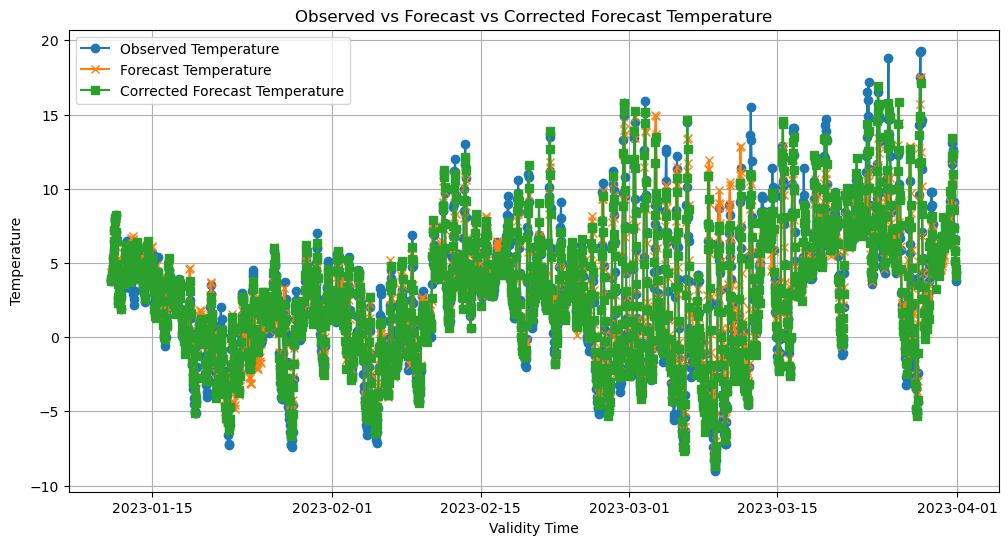

In [102]:
# Plotting the time series
plt.figure(figsize=(12, 6))

plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['obs_temp'], label='Observed Temperature', marker='o')
plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['forecast_temp'], label='Forecast Temperature', marker='x')
plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['corrected_forecast_temp'], label='Corrected Forecast Temperature', marker='s')

plt.xlabel('Validity Time')
plt.ylabel('Temperature')
plt.title('Observed vs Forecast vs Corrected Forecast Temperature')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_76904/4219330908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_mean_error['corrected_error'] = df_with_mean_error['corrected_forecast_temp'] - df_with_mean_error['obs_temp']


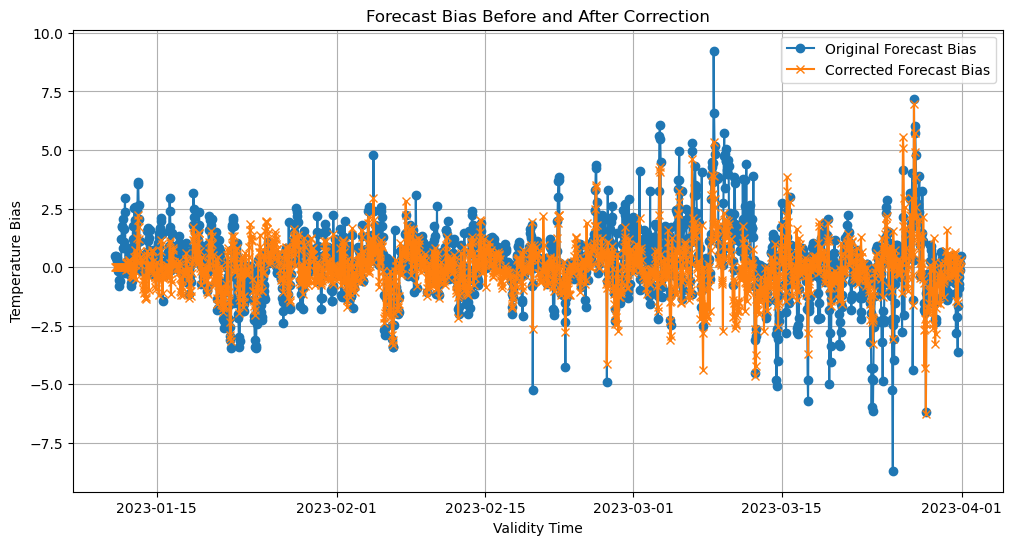

In [104]:
# Calculate the corrected error (bias) after correction
df_with_mean_error['corrected_error'] = df_with_mean_error['corrected_forecast_temp'] - df_with_mean_error['obs_temp']

# Plotting the bias before and after correction
plt.figure(figsize=(12, 6))

plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['error'], label='Original Forecast Bias', marker='o')
plt.plot(df_with_mean_error['validity_time'], df_with_mean_error['corrected_error'], label='Corrected Forecast Bias', marker='x')

plt.xlabel('Validity Time')
plt.ylabel('Temperature Bias')
plt.title('Forecast Bias Before and After Correction')
plt.legend()
plt.grid(True)
plt.show()

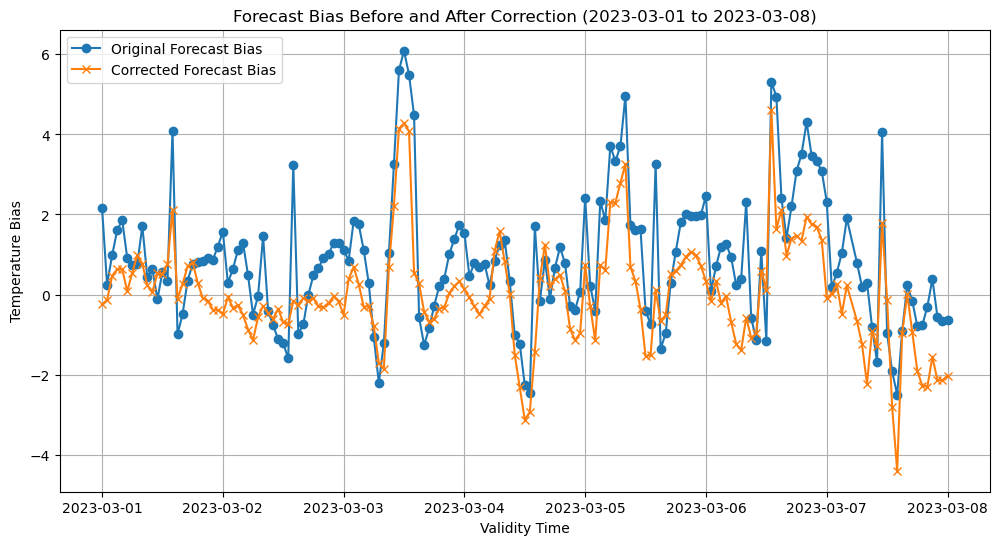

In [105]:
### Plot only a particular date range

# Specify the date range to filter
start_date = '2023-03-01'
end_date = '2023-03-08'

# Filter the DataFrame to the specified date range
mask = (df_with_mean_error['validity_time'] >= start_date) & (df_with_mean_error['validity_time'] <= end_date)
filtered_df = df_with_mean_error[mask]

# Plotting the bias before and after correction for the filtered date range
plt.figure(figsize=(12, 6))

plt.plot(filtered_df['validity_time'], filtered_df['error'], label='Original Forecast Bias', marker='o')
plt.plot(filtered_df['validity_time'], filtered_df['corrected_error'], label='Corrected Forecast Bias', marker='x')

plt.xlabel('Validity Time')
plt.ylabel('Temperature Bias')
plt.title(f'Forecast Bias Before and After Correction ({start_date} to {end_date})')
plt.legend()
plt.grid(True)
plt.show()